# Project Overview

# Introduction and Overview


I decided to test out the new **YOLOv10** model by building my own face detection application. This project demonstrates a comprehensive approach to creating an advanced face recognition system using YOLOv10.

## Process

The process begins with the collection and organization of user images, followed by semi-automated labeling using a face detection model to generate accurate annotations. To ensure the dataset's diversity and robustness, data augmentation techniques such as flipping, brightness adjustments, and gamma shifts were applied. After preparing the data and converting annotations to a format compatible with YOLO models, the YOLOv10 model was trained using Google Colab for optimized computation.

Finally, the trained model was deployed for real-time object detection via a webcam, showcasing its practical application and effectiveness in accurately recognizing and labeling faces in a dynamic environment.


### **IMPORTANT NOTE**: Run this notebook on the local machine.

Without further ado, let's get right into it!

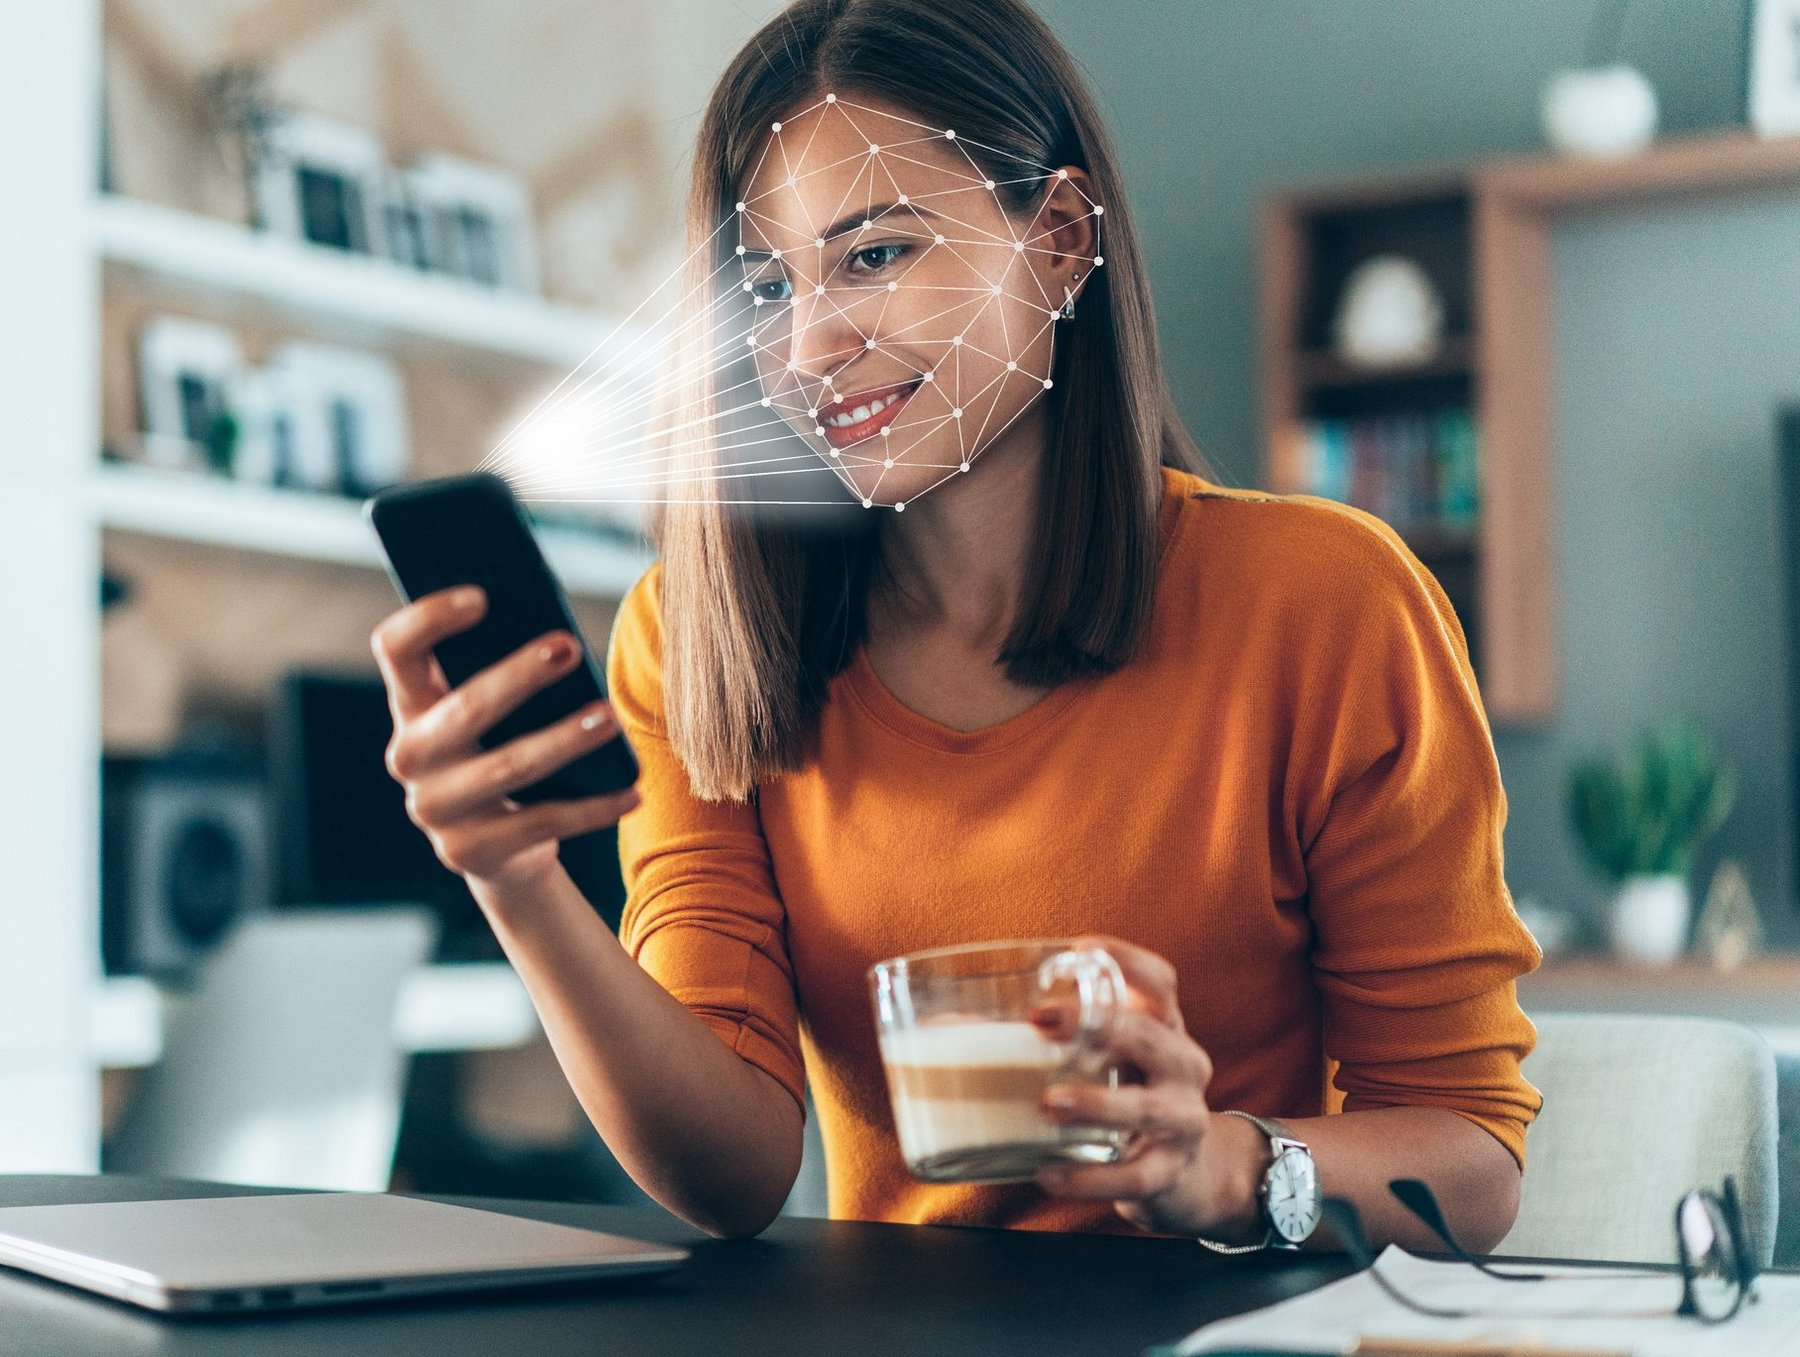

# Imports


In [ ]:
import os
import time
import uuid
import os
import cv2
import shutil
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import importlib.util
import sys
import random
import albumentations as alb
import numpy as np
import supervision as sv

# File Architecture

The process of organizing files and building the correct file architecture will be broken down into two main steps:

- First, create a directory for this project.
- Then add `labelme2yolo.py` and `face_detection.py` to the directory
---
- Run the code below to create all the necessary folders in your project directory.
    - **Important note:** Make sure that you specify the path of your main project directory in the `path` variable.

In [ ]:
## This code will help you to create necessary folders for the project

def create_folders(path):
    folders_to_create = [os.path.join(path, 'images'),
                         os.path.join(path, 'labels'),
                         os.path.join(path, 'raw_user_images')
                         ]

    for i in folders_to_create:
        if not os.path.exists(i):
            os.makedirs(i)
            print(f'{i} was created at {path}')
        else:
            print ('Folders already exist')

path = 'YOUR_PATH_TO_THE_PROJECT_DIRECTORY'
create_folders(path)

# Collecting Images For Each User

## Overview

In this step, we will collect the primary data for each user to be recognized by your model. The process will follow these steps:

- Create a folder in the **raw_user_images** directory and name it after the first name of the user you are taking pictures of.
- Update the `img_path` variable to point to the user directory you just created.
- Run the code to open your camera and take pictures.

- For other users, repeat the process desribed above.

## How to Take Images

- Update the `img_path` variable to point to the user directory.
- Specify the number of images you want to take per user.
    - **Important Note**: I recommend capturing at least 35 images.
- Run the code provided below to collect images using the OpenCV application.
    - When the application is open, press `c` to capture an image.
    - After you have taken all the images, press `q` to quit the application.
- For better results, make sure the images are taken in a location with good lighting and a simple, uncluttered background. Move around to capture your face from various angles within the frame.

In [ ]:
 # Directory to save images -- FOLLOW INSTRUCTIONS ABOVE
img_path = 'YOUR_PROJECT_PATH/raw_user_images/USERS_NAME'
# Number of images to capture
number_images = 35

In [ ]:
# Initialize the camera
cap = cv2.VideoCapture(1)

# Counter for captured images
imgnum = 0

print("Press 'c' to capture an image. Press 'q' to quit.")

while imgnum < number_images:
    # Read a frame from the camera
    ret, frame = cap.read()

    # Display the frame
    cv2.imshow('frame', frame)

    # Wait for a key press
    key = cv2.waitKey(1) & 0xFF

    # If 'c' is pressed, capture the image
    if key == ord('c'):
        print(f'Collecting image {imgnum+1}')
        imgname = os.path.join(img_path, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        imgnum += 1

    # If 'q' is pressed, exit the loop
    elif key == ord('q'):
        break

# Release the camera and close the window
cap.release()
cv2.destroyAllWindows()

**IMPORTANT:** Repeat this process for all the additional users you want to include. Once you have collected images for all users, we will move on to the labeling part of the project.

# Semi-Automated Image Labeling

## Overview
The goal of this section is to draw bounding boxes around faces in every image and label them, creating specialized JSON files with the bounding box coordinates. To achieve this, we will use a Multi-Task Cascaded Convolutional Neural Network (MTCNN) which detects faces and facial landmarks in images. You can read more about this neural network [here](https://medium.com/@saranshrajput/face-detection-using-mtcnn-f3948e5d1acb).

## Process

- First, we initialize the face detection model (face_decetion.py) to identify faces and landmarks in images.
- Next, we generate JSON files that contain bounding box coordinates for detected faces in images.
- Then, we specify paths for the following directories: `raw_user_images`, `output_folder`, `main_images`, `no_face_detected`:
    - `raw_user_images`: Path to the directory containing raw images of users.
    - `output_folder`: Path where JSON labels will be saved (called `labels`).
    - `main_images`: Path where images with detected faces will be copied (called `images`).
    - `no_face_detected`: Path where images with no detected faces will be moved.
    - `no_face_detected_labels`: Path where  JSON labels for images with no detected faces will be saved.

**IMPORTANT**: You need to provide a valid path for `no_face_detected`. This step really ensures the script runs smoothly even if no faces are undetected. Specify the path by adding your base directory before `/raw_user_images/no_face_detected`. For example:

`no_face_detected = r'/Your/Base/Directory/raw_user_images/no_face_detected`


In [ ]:
# IMPORTANT: Replace 'YOUR_PROJECT_DIRECTORY' with the name of your project directory
from YOUR_PROJECT_DIRECTORY.face_detection import FaceDetector

In [ ]:
model = FaceDetector()
def create_json(image_shape, boxes, filename, label, image_data, output_folder):
    points = [[boxes[0], boxes[1]], [boxes[2], boxes[3]]]
    shape = {
        "label": label,
        "points": points,
        "group_id": None,
        "description": "",
        "shape_type": "rectangle",
        "flags": {},
        "mask": None
    }

    json_data = {
        "version": "5.4.1",
        "flags": {},
        "shapes": [shape],
        "imagePath": filename,
        "imageData": image_data,
        "imageHeight": image_shape[0],
        "imageWidth": image_shape[1]
    }
    output_filename = os.path.splitext(filename)[0] + '.json'
    with open(os.path.join(output_folder, output_filename), 'w') as json_file:
        json.dump(json_data, json_file, indent=4)
    print(f"JSON data has been saved to {output_folder}")
    return json_data

# IMPORTANT: Specify your paths for the following directories:
raw_user_images = r'YOUR_PROJECT_PATH/raw_user_images'
output_folder = r'YOUR_PROJECT_PATH/labels'
main_images = r'YoUR_PROJECT_PATH/images'
no_face_detected = r'YOUR_PROJECT_PATH/raw_user_images/no_face_detected'
no_face_detected_labels = r'YOUR_PROJECT_PATH/raw_user_images/no_face_detected_labels' # IMPORTANT
# Function to create labels
def create_labels(raw_folder):
    no_bbox_files = []
    for user_folder in os.listdir(raw_folder):
        user_folder_path = os.path.join(raw_folder, user_folder)
        if not os.path.isdir(user_folder_path):
            continue
        class_label = os.path.basename(user_folder_path)
        filenames = os.listdir(user_folder_path)

        for i in filenames:
            image_path = os.path.join(user_folder_path, i)
            if not os.path.isfile(image_path) or not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            bbox, img_with_boxes = model.detect_faces(image_path=image_path)

            if bbox is not None:
                create_json(image_shape=[1280, 640],
                            boxes=bbox[0],
                            filename=i,
                            label=class_label,
                            image_data=None,
                            output_folder=output_folder)
                shutil.copy(image_path, main_images)
            else:
                print(f'File {i} has no faces detected. It has been added to a list of filenames, which you can delete or label later.')
                no_bbox_files.append(image_path)

    return no_bbox_files


# Run the function and move files with no faces detected
no_face = create_labels(raw_folder=raw_user_images)

# Create the no_face_detected and no_face_detected_labels directories only if needed
os.makedirs(no_face_detected, exist_ok=True)
os.makedirs(no_face_detected_labels, exist_ok=True)

for i in no_face:
    shutil.move(i, no_face_detected)

print(f'Files in label folder: {len(os.listdir(output_folder))}')
print(f'Files in no_face_detected folder: {len(os.listdir(no_face_detected))}')


Congratulations! You've successfully completed the image labeling process. Your images are now ready for the next steps in your project. Great job!

## Dealing With Undetected Faces: Image Labeling with LabelMe


### Step 1: Open LabelMe and Load Images
1. Run `!labelme` to open LabelMe.
2. Click "File" in the top left corner and select "Open Dir".
3. Navigate to and open the `no_face_detected` folder created earlier.

### Step 2: Display Images
1. Make sure that your images from the `no_face_detected` folder are displayed in the "File List" at the bottom right of the interface.
 - **Suggestion:** Use "a" and "d" to navigate between images.

### Step 3: Set Output Directory
1. Click "File" again and select "Change Save Dir".
2. Set the output directory to the `no_face_detected_labels` folder.

### Step 4: Enable Auto-Save
1. Click "File" and enable "Save Automatically". This ensures annotations are saved in the `no_face_detected_labels` folder.

### Step 5: Create Annotations
1. Select an image from the "File List".
2. Right-click on the image and select "Create Rectangle".
3. Draw the bounding box by specifying the top left and bottom right corners.
4. Label the image by typing the class name in the displayed dialog box and click "OK".

### Step 6: Save Annotations
- Your annotations and bounding box coordinates will be automatically saved as JSON files in the `no_face_detected_labels` folder.


In [ ]:
'''Run this cell to initiale LabelMe'''
# Use labelme for images that are located in `no_face_detected` folder
!labelme # a & d allows you to go back and forth

After you are done with labeling the undetected images, move these files to the main `images` and `labels` directories.

In [ ]:
# Define paths
base_dir = r'YOUR_PROJECT_PATH'
source_images = os.path.join(base_dir, 'raw_user_images/no_face_detected')
source_labels = os.path.join(base_dir, 'raw_user_images/no_face_detected_labels')
target_images = os.path.join(base_dir, 'images')
target_labels = os.path.join(base_dir, 'labels')

# making sure that target directories exist
os.makedirs(target_images, exist_ok=True)
os.makedirs(target_labels, exist_ok=True)

# moving images
for filename in os.listdir(source_images):
    source_path = os.path.join(source_images, filename)
    target_path = os.path.join(target_images, filename)
    if os.path.isfile(source_path):
        shutil.move(source_path, target_path)
        print(f'Moved image: {filename}')

# and moving labels
for filename in os.listdir(source_labels):
    source_path = os.path.join(source_labels, filename)
    target_path = os.path.join(target_labels, filename)
    if os.path.isfile(source_path):
        shutil.move(source_path, target_path)
        print(f'Moved label: {filename}')


## What to do if too many faces are being undetected by the pretrained model

If too many faces are being undetected by the pretrained model, you can try adjusting the confidence thresholds. Head to face_detection.py and experiment with different values in the thresholds parameter in the __init__ method of the FaceDetector class.


Lowering these threshold values can help the model detect more faces, but it may also increase the likelihood of false positives. Based on my experience so far, a threshold of 0.95 works well.

To lower the treshholds
1. Open the `face_detection.py` file
2. Find and adjust this part of the code `def __init__(self, device=None, thresholds=[0.95, 0.95, 0.95]):`
3. Run the file to save the changes

## Optional: Delete images from USER_NAME directories

In [ ]:
for user_folder in os.listdir(raw_user_images):
    user_folder_path = os.path.join(raw_user_images, user_folder)
    if os.path.isdir(user_folder_path):
        for file in os.listdir(user_folder_path):
            file_path = os.path.join(user_folder_path, file)
            os.remove(file_path)
            print(f'Deleted {file} from {user_folder_path}')


# Sanity Check #1

The goal of this sanity check is to confirm that images and their corresponding labels were uploaded in the expected format. Here we are going to load each image and its label, and display the image with the bounding box to verify correctness.

In [ ]:
'''FIRST MAJOR SANITY CHECK
The goal of the first sanity check is to confirm that images and their corresponding labels were uploaded in the expected format

Status: CheckPoint Satisfied
'''

### define the base directory for all data
base_directory = 'YOUR_PROJECT_PATH'

# function to load images
def load_image(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    return img

# displaying image with bounding box
def display_image_with_bounding_box(image_path, label_path):
    """Load and display an image along with its corresponding bounding box."""
    try:
        # Load and decode the image
        byte_img = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(byte_img, channels=3)

        # Load label
        with open(label_path, 'r') as file:
            label = json.load(file)

        # Extract bounding box and class label from JSON
        bbox = label['shapes'][0]['points']
        class_name = label['shapes'][0]['label']

        # Display image and bounding box
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(image.numpy())
        rect = patches.Rectangle((bbox[0][0], bbox[0][1]),
                                  bbox[1][0] - bbox[0][0],
                                  bbox[1][1] - bbox[0][1],
                                  linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.title(f"Class: {class_name}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Failed to load or display {image_path}: {e}")

# directories for images and labels
image_dir = os.path.join(base_directory, 'images')
label_dir = os.path.join(base_directory, 'labels')

# here we want to list all image files and their corresponding label files
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.json')])

# displaying all images and labels
for image_path, label_path in zip(image_files, label_files):
    display_image_with_bounding_box(image_path, label_path)


If all your images are displayed with correct bounding boxes around them, it means you're on the right track! Great job :)

# Image Split

Next step would be to split your dataset into three different directories: Training, Validation, and Testing.
- **Importnat Note:** Users can specify the split percentages for each dataset by modifying the lines:

In [ ]:
## add this part to the markdown above
total_files = len(all_files)
train_split = int(0.7 * total_files) ### Specify percentage HERE
val_split = int(0.14 * total_files) ### Specify percentage HERE


In [ ]:
'''Adding some automated image split into 3 different directories (files):
1. Training
2. Validation
3. Testing

'''

## base path to your ImageRecognition directory
base_path = 'YOUR_PROJECT_PATH'

#sourse and destination directories
source_dir = os.path.join(base_path, 'images')
train_dir = os.path.join(base_path, 'train/images')
val_dir = os.path.join(base_path, 'val/images')
test_dir = os.path.join(base_path, 'test/images')

# ensuring destination directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

## If you're using Mac, we suggest to filter out .DS_Store

all_files = [f for f in os.listdir(source_dir) if f != '.DS_Store']
random.shuffle(all_files)  # Shuffle to ensure random distribution

# calculating the split indices
total_files = len(all_files)
train_split = int(0.7 * total_files) ### Specify percentage HERE
val_split = int(0.14 * total_files) ### Specify percentage HERE

# splitting the files into train, val, and test
train_files = all_files[:train_split]
val_files = all_files[train_split:train_split + val_split]
test_files = all_files[train_split + val_split:]

# moving files to respective directories
for file in train_files:
    shutil.move(os.path.join(source_dir, file), train_dir)
for file in val_files:
    shutil.move(os.path.join(source_dir, file), val_dir)
for file in test_files:
    shutil.move(os.path.join(source_dir, file), test_dir)

print(f"Moved {len(train_files)} files to train/images")
print(f"Moved {len(val_files)} files to val/images")
print(f"Moved {len(test_files)} files to test/images")
print (f'Total files processed: {len(train_files) + len(val_files) + len(test_files)}')


### Labels Split

This chunk of code iterates over the `train`, `test`, and `val` folders, and assigns labels to the already sorted images by moving the corresponding `.json` label files from the `labels` directory to the appropriate subdirectories within each folder.

In [ ]:

## Make sure to specify the base_path
base_path = 'YOUR_PROJECT_PATH'

for folder in ['train', 'test', 'val']:
    image_folder = os.path.join(base_path, folder, 'images')
    for file in os.listdir(image_folder):
        print(file)

        filename = file.split('.')[0] + '.json'
        print(filename)
        existing_filepath = os.path.join(base_path, 'labels', filename)
        print(existing_filepath)

        if os.path.exists(existing_filepath):
            print('Executing')
            new_filepath = os.path.join(base_path, folder, 'labels', filename)
            print(new_filepath)

            os.replace(existing_filepath, new_filepath)

# Optional: Sanity Check #2

This sanity check is optional but it ensures that all images and their corresponding `.json` labels are correctly sorted and matched in the `train`, `val`, and `test` directories. The code allows you to load each image and plot its bounding boxes from the `.json` files. If bounding boxes and images match, we can visually verify the correctness of the annotations. If everything worked as intended, we are ready for image augmentation.

In [ ]:
base_directory = 'YOUR_PROJECT_PATH'

def load_and_display_image_with_label(image_path, label_path):
    """Load and display an image along with its corresponding label and bounding box."""
    try:
        # loading and decode the image
        byte_img = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(byte_img, channels=3)

        # loading label
        with open(label_path, 'r') as file:
            label = json.load(file)

        # extracting bounding box
        bbox = label['shapes'][0]['points']
        xmin, ymin = bbox[0]
        xmax, ymax = bbox[1]


        fig, ax = plt.subplots(1)
        ax.imshow(image.numpy())
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.title(f"Label: {label['shapes'][0]['label']}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Failed to load or display {image_path}: {e}")

sub_dirs = ['train', 'val', 'test']

for sub_dir in sub_dirs:
    image_dir = os.path.join(base_directory, sub_dir, 'images')
    label_dir = os.path.join(base_directory, sub_dir, 'labels')

    images = sorted(os.listdir(image_dir))
    labels = sorted(os.listdir(label_dir))

    for image_name, label_name in zip(images, labels):
        image_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, label_name)
        load_and_display_image_with_label(image_path, label_path)

Now that we have successfully split our data into training, validation, and test sets, it's time to perform augmentations to expand our dataset. Congratulations on making it this far—great job!

# Image Augmentation

In this section, we finally perform image augmentation using the Albumentations library, which I found to be one of the fastest and most flexible libraries for image augmentation. The overall idea of image augmentation is the application of various image transformations, which allows us to expand our dataset and improve the robustness of our models.

## Augmentation Pipeline
We use the following augmentations to expand and enhance our dataset:

- Horizontal Flip: Flips the image horizontally with a probability of 0.5.
- Random Brightness and Contrast: Adjusts the brightness and contrast with a probability of 0.2.
- Random Gamma: Changes the gamma value with a probability of 0.2.
- RGB Shift: Shifts the RGB values with a probability of 0.2.
- Vertical Flip: Flips the image vertically with a probability of 0.5.


**Important note:** At the beggining of the code snipped below, make sure to **define the class labels**. It's crucial as it allows us to map each label to a corresponding numeric value, which is required for the augmentation and later stages of the training process.



## Augmentation Process

For each image in the `train`, `test`, and `val` folders, the script I wrote performs the following steps:

- Loads the image and its corresponding label.
- Applies the augmentation pipeline to generate multiple augmented versions of the image.
- Saves the augmented images and their corresponding labels in the appropriate directories.

If you are interested in learning more about image augmentations and the Albumentations library, visit Albumentations Documentation. https://albumentations.ai/docs/


In [ ]:
# IMPORTANT: Define the class labels
class_labels = {
    'Anthony': 0,
    'Diane': 1
}  # Add more if needed

# Augmentation pipeline -- modify if needed
img_augmentor = alb.Compose([
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

# Base directory
base_directory = 'YOUR_PROJECT_PATH'

# Iterating over each subdirectory
for sub_dir in ['train', 'test', 'val']:
    image_folder = os.path.join(base_directory, sub_dir, 'images')

    # Ensure the aug_data directories exist
    aug_image_dir = os.path.join(base_directory, sub_dir, 'aug_data', 'images')
    aug_label_dir = os.path.join(base_directory, sub_dir, 'aug_data', 'labels')
    os.makedirs(aug_image_dir, exist_ok=True)
    os.makedirs(aug_label_dir, exist_ok=True)

    for image in os.listdir(image_folder):
        print(f'Processing image: {image}')
        img = cv2.imread(os.path.join(image_folder, image))
        if img is None:
            print(f'Failed to load image: {image}')
            continue  # Skip if the image is not loaded properly

        label_path = os.path.join(base_directory, sub_dir, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            if 'shapes' in label:
                for shape in label['shapes']:
                    coords = [shape['points'][0][0], shape['points'][0][1],
                              shape['points'][1][0], shape['points'][1][1]]
                    coords = list(np.divide(coords, [1280, 720, 1280, 720]))  # Normalize coordinates
                    class_label = class_labels.get(shape['label'])

                    if class_label is not None:  # Proceed only if a valid class label is found
                        try:
                            for x in range(60):  # Augment each image 60 times
                                augmented = img_augmentor(image=img, bboxes=[coords], class_labels=[class_label])
                                aug_img_path = os.path.join(aug_image_dir, f'{image.split(".")[0]}.{x}.jpg')
                                cv2.imwrite(aug_img_path, augmented['image'])

                                # Create augmented label JSON with the original format
                                aug_label = {
                                    "version": label["version"],
                                    "flags": label["flags"],
                                    "shapes": [{
                                        "label": shape["label"],
                                        "points": [
                                            [augmented['bboxes'][0][0] * 1280, augmented['bboxes'][0][1] * 720],
                                            [augmented['bboxes'][0][2] * 1280, augmented['bboxes'][0][3] * 720]
                                        ],
                                        "group_id": shape["group_id"],
                                        "description": shape["description"],
                                        "shape_type": shape["shape_type"],
                                        "flags": shape["flags"],
                                        "mask": shape["mask"]
                                    }],
                                    "imagePath": f'{image.split(".")[0]}.{x}.jpg',
                                    "imageData": None,
                                    "imageHeight": label["imageHeight"],
                                    "imageWidth": label["imageWidth"]
                                }

                                aug_label_path = os.path.join(aug_label_dir, f'{image.split(".")[0]}.{x}.json')
                                with open(aug_label_path, 'w') as f:
                                    json.dump(aug_label, f)
                                print(f'Saved augmented image and label: {aug_img_path}, {aug_label_path}')

                        except Exception as e:
                            print(f'Error processing image {image}: {e}')


# Optional: Sanity Check #3

Another optional sanity check to make sure your augmented images and labels are correctly generated and aligned.



In [ ]:
# Base directory
base_directory = 'YOUR_PROJECT_PATH'

def load_and_display_augmented_image_with_label(image_path, label_path):
    """Load and display an augmented image along with its corresponding label and bounding box."""
    try:
        # loading augmented images
        img = cv2.imread(image_path)
        if img is None:
            print(f'Failed to load image: {image_path}')
            return

        # loading labels
        with open(label_path, 'r') as file:
            label = json.load(file)

        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # plotting bounding boxes
        shape = label['shapes'][0]  # Assume there is only one shape per image
        points = shape['points']
        xmin, ymin = points[0]
        xmax, ymax = points[1]

        # converting normalized coordinates back to absolute coordinates
        img_height, img_width, _ = img.shape
        xmin = xmin / 1280 * img_width
        xmax = xmax / 1280 * img_width
        ymin = ymin / 720 * img_height
        ymax = ymax / 720 * img_height

        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

        plt.title(f"Label: {shape['label']}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Failed to load or display {image_path}: {e}")

sub_dirs = ['train', 'val', 'test']
num_samples = 3  ######### IMPORTANT: Specify the number of samples to visualize per sub-directory #########

for sub_dir in sub_dirs:
    aug_image_dir = os.path.join(base_directory, sub_dir, 'aug_data', 'images')
    aug_label_dir = os.path.join(base_directory, sub_dir, 'aug_data', 'labels')

    aug_images = sorted(os.listdir(aug_image_dir))[:num_samples]
    aug_labels = sorted(os.listdir(aug_label_dir))[:num_samples]

    for aug_image_name, aug_label_name in zip(aug_images, aug_labels):
        aug_image_path = os.path.join(aug_image_dir, aug_image_name)
        aug_label_path = os.path.join(aug_label_dir, aug_label_name)

        # Debugging prints
        print(f"Processing augmented image: {aug_image_path}")
        print(f"Processing augmented label: {aug_label_path}")

        load_and_display_augmented_image_with_label(aug_image_path, aug_label_path)


Great job! Now that we've completed image augmentation, the next step is model training. However, before we begin training the model, we need to ensure that our data is properly structured for YOLO based models.

# Converting JSON Files Into TXT

YOLO models only accept labels in a very specific format, which is a `.txt` file. This format is necessary because YOLO uses a particular structure for annotations: each line in the `.txt` file represents one bounding box and contains five variables—class number, x-center, y-center, width, and height—all normalized between 0 and 1.

Here's what each variable means:
- **class number**: The numeric identifier of the class (e.g., 0 for the first class, 1 for the second class, etc.).
- **x-center**: The normalized x-coordinate of the center of the bounding box.
- **y-center**: The normalized y-coordinate of the center of the bounding box.
- **width**: The normalized width of the bounding box.
- **height**: The normalized height of the bounding box.

The following script converts JSON label files into the required YOLO format `.txt` files, and saves them in `train`, `val`, and `test` folders, in a new directory called `labels_txt`.

For this task, we are going to use a function from the [GitHub page Labelme2YOLO](https://github.com/rooneysh/Labelme2YOLO/blob/main/ ), which I have modified for our specific application.

In [ ]:
# IMPORTANT: Specify the path to the JSON-TXT converter script
script_path = 'YOUR_PROJECT_PATH/labelme2yolo.py'

# load the module
spec = importlib.util.spec_from_file_location("labelme2yolo", script_path)
labelme2yolo = importlib.util.module_from_spec(spec)
sys.modules["labelme2yolo"] = labelme2yolo
spec.loader.exec_module(labelme2yolo)

# IMPORTANT: Specify the directory for the project
base_dir = "YOUR_PROJECT_PATH"

# sub-directories for train, test, and val
sub_dirs = ["train", "test", "val"]

# looping through each subdirectory and perform the conversion
for sub_dir in sub_dirs:
    input_dir = os.path.join(base_dir, sub_dir, "aug_data", "labels")
    output_dir = os.path.join(base_dir, sub_dir, "aug_data", "labels_txt")
    images_dir = os.path.join(base_dir, sub_dir, "aug_data", "images")

    # making sure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # creating an instance of the Labelme2YOLO class
    converter = labelme2yolo.Labelme2YOLO(json_dir=input_dir, output_dir=output_dir, images_dir=images_dir)

    # performing the conversion
    converter.convert()

    # Optional: Check the output
    print(f"Converted files are saved in: {output_dir}")


### Creating a YAML file to specify directories for the YOLO models

In order to train our YOLO models, we need to create a YAML file that specifies the directories for our training, validation, and test datasets. This YAML file will be used by the YOLO model to locate the images and their corresponding labels during training and evaluation.

The `data.yaml` file contains the following information:

- **names**: This section lists the names of the classes in our dataset.
- **nc**: This specifies the number of classes, which is 2 in our case.
- **train**: The directory path where the training images are stored.
- **val**: The directory path where the validation images are stored.
- **test**: The directory path where the test images are stored.

Here is the code that creates the data.yaml file with the necessary content:

In [ ]:
import os

# Define the directory and file paths
project_dir = "YOUR_PROJECT_PATH"
yaml_file_path = os.path.join(project_dir, "data.yaml")

# Content for the data.yaml file
yaml_content = """
names:
- Anthony
- Diane
nc: 2
test: YOUR_PROJECT_PATH/test/aug_data/images
train: YOUR_PROJECT_PATH/V3_ImageRecognition/train/aug_data/images
val: YOUR_PROJECT_PATH/val/aug_data/images
"""

# Create and write the content to the yaml file
with open(yaml_file_path, "w") as yaml_file:
    yaml_file.write(yaml_content)

print(f"data.yaml file created at: {yaml_file_path}")


# Data Structurization for YOLO model

When YOLO reads the YAML file and processes the specified train and validation directories, it automatically identifies labels from the same folder (in our case, `aug_data`). Currently, we have two label folders in each `aug_data` directory: `labels` (containing JSON files) and `labels_txt` (containing the TXT files required by the YOLO model).

YOLO requires a very specific file structure, so we need to make the following adjustments:

- Remove the JSON labels from the `aug_data` directory.
- Rename the `labels_txt` folder to labels.

This will ensure that the YOLO model can correctly find and use the label files.

**Important Note:** This step is required if you're trying to run the YOLO-based model, but most other models use JSON labels. If you're using a different model, feel free to skip this step or modify the code to meet the requirements of your project.

In [ ]:
# base directory
base_directory = 'YOUR_PROJECT_PATH'

# run this function to clean and rename label directories
def clean_and_rename_label_dirs(base_dir, sub_dirs):
    for sub_dir in sub_dirs:
        aug_data_dir = os.path.join(base_dir, sub_dir, 'aug_data')
        labels_dir = os.path.join(aug_data_dir, 'labels')
        labels_txt_dir = os.path.join(aug_data_dir, 'labels_txt')

        # step 1: removing the JSON labels directory if it exists
        if os.path.exists(labels_dir):
            shutil.rmtree(labels_dir)
            print(f"Removed JSON labels directory: {labels_dir}")

        # step 2: renaming the labels_txt directory to labels
        if os.path.exists(labels_txt_dir):
            new_labels_dir = os.path.join(aug_data_dir, 'labels')
            os.rename(labels_txt_dir, new_labels_dir)
            print(f"Renamed {labels_txt_dir} to {new_labels_dir}")

# subdirectories to process
sub_dirs = ['train', 'val', 'test']

# executing the function
clean_and_rename_label_dirs(base_directory, sub_dirs)

print("Data structuring for YOLO model completed.")


Now we have everything ready for the most exiting part of the project - model training!  

# YOLOv10: Importing the Model and Downloading Weights

In this script we set up the YOLOv10 model and making sure that all the necessary packages are installed. Also, we download the model and its weights from the official GitHub repository, and organize the files in a structured manner.
- The script creates a directory named `YOLOv10_MODEL` in the base directory to store the model weights and example data
- The script also verifies the successful installation and loading of the YOLOv10 model.
- The script runs YOLOv10 inference on an example image to verify that the model is working correctly.

In [ ]:
from ultralytics import YOLOv10

# definiting the base directory
HOME = os.getcwd()
BASE_DIR = os.path.join(HOME, "YOLOv10_MODEL")
os.makedirs(BASE_DIR, exist_ok=True)

# defining paths for weights and data
weights_dir = os.path.join(BASE_DIR, "weights")
data_dir = os.path.join(BASE_DIR, "data")
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# making sure that necessary packages are installed
os.system("pip install transformers")
os.system("pip install supervision roboflow")

# installing the YOLOv10 model from the official GitHub page
os.system("pip install git+https://github.com/THU-MIG/yolov10.git")

# verifying YOLOv10 installation
try:
    from yolov10 import YOLOv10
    print("YOLOv10 installed and imported successfully!")

    # Load the YOLOv10 model with specified weights
    model_path = os.path.join(weights_dir, "yolov10n.pt")
    model = YOLOv10(model_path)
    print("YOLOv10 model loaded successfully!")
except ImportError as e:
    print(f"ImportError: {e}")
except Exception as e:
    print(f"Error: {e}")

# downloading weights
weights = [
    "yolov10n.pt", "yolov10s.pt", "yolov10m.pt",
    "yolov10b.pt", "yolov10x.pt", "yolov10l.pt"
]

for weight in weights:
    os.system(f"wget -P {weights_dir} -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/{weight}")

# listing the downloaded weights
os.system(f"ls -lh {weights_dir}")

# downlo example data
os.system(f"wget -P {data_dir} -q https://media.roboflow.com/notebooks/examples/dog.jpeg")

# listing the downloaded data
os.system(f"ls -lh {data_dir}")

# running YOLOv10 inference using the CLI
os.system(f"yolo task=detect mode=predict conf=0.25 save=True model={weights_dir}/yolov10n.pt source={data_dir}/dog.jpeg")

# displaying the result image
from IPython.display import Image
Image(filename=f'{HOME}/runs/detect/predict/dog.jpeg', height=600)


# YOLOv10 - Training and Results on a Local Machine

YOLOv10, a state-of-the-art object detection model, was released recently and has quickly gained popularity for its accuracy and efficiency. It comes with different pre-trained weights, each catering to various needs:

- **YOLOv10-N (Nano)**: Smallest and fastest with 2.3M parameters, suitable for applications requiring low latency.
- **YOLOv10-S (Small)**: Balances speed and accuracy with 7.2M parameters.
- **YOLOv10-M (Medium)**: Offers higher accuracy with 15.4M parameters.
- **YOLOv10-B (Base)**: Provides a good trade-off between speed and accuracy with 19.1M parameters.
- **YOLOv10-L (Large)**: Higher accuracy with 24.4M parameters.
- **YOLOv10-X (Extra Large)**: Highest accuracy with 29.5M parameters but also the highest computational cost.
I decided to use the Nano version (YOLOv10-N) due to its balance of speed and performance, but users are welcome to experiment with other versions based on their requirements.

When using this model, users need to specify the model and data fields. All the hyperparameters are tunable, and you can adjust them to fit your application. However, the settings I used worked well for this project and suited all my needs.

Here's the code snippet for running YOLOv10 training:

In [ ]:

!yolo task=detect mode=train epochs=25 batch=32 workers = 8  plots=True \
model= YOUR_PROJECT_PATH/YOLOv10_MODEL/weights/yolov10n.pt \
data='YOUR_PROJECT_PATH/data.yaml'

# YOLOv10 - Training and Results in Google Collab

I ran this model in Google Colab as I didn't have enough disk memory to run this code on my local machine. Therefore, I had to do the following steps to run it in Colab (this is relevant to people who are also unable to run this code locally):

- **Step 1**: Download your train, val, and test augmented images in the same format they are now at this point of the project (PROJECT_PATH/train(or val, or test)/aug_data/images(or labels)).

- **Step 2**: Download the YAML file and update the train, val, and test paths since now they are in Colab.

- **Step 3**: Install the model and weights in the Colab notebook.

- **Step 4**: Make sure to change the runtime to T4 GPU.

- **Step 5**: Run the model using the same snippet provided below but don't forget to update the 'data' field.

- **Step 6**: After the model is done running, make sure to save the file with the best weights called "best.pt". We're going to need it to run inference on our webcam, which is the end goal of this project.


In [ ]:
# Load the trained YOLOv10 model
model_path = 'YOUR_PROJECT_PATH/best.pt'
model = YOLOv10(model_path)

# Create annotators for bounding boxes and labels
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Initialize webcam
cap = cv2.VideoCapture(1)  # Try changing to VideoCapture(1) or another index if you have multiple cameras

if not cap.isOpened():
    print('Unable to read camera feed')
    exit()

print('Press ESC to exit.')

while True:
    ret, frame = cap.read()

    if not ret:
        print('Failed to grab frame')
        break

    # Run YOLOv10 inference
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Annotate the frame
    annotated_image = bounding_box_annotator.annotate(scene=frame, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display the annotated frame
    cv2.imshow('Webcam', annotated_image)

    k = cv2.waitKey(1)

    # Exit loop when ESC is pressed
    if k % 256 == 27:
        print('Escape hit, closing...')
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()


# Project Conclusion

In this project, we successfully implemented a robust face recognition pipeline using the YOLOv10 model, which involved the collection, annotation, augmentation, and training of a custom dataset.

By leveraging advanced techniques like image augmentation and YOLO-based object detection, we achieved accurate and efficient recognition of multiple individuals.

This VERY comprehensive workflow not only ensured high-quality model performance but also demonstrated the practical application of state-of-the-art deep learning methods for real-time face detection. Overall, the project highlights the effectiveness of combining meticulous data preparation with powerful deep learning algorithms to address complex recognition tasks.

Thank you for your attention, and if you have any questions or would like to discuss the project further, please feel free to reach out to me on [LinkedIn](https://www.linkedin.com/in/anthonynavarro14/).